# Predicting Water Quality: Safe or Not Safe for Consumption  #

<img src="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExZWgyMTlmdjk3aHFjejM0ZGp1ZjhlYnBjbGIwbjM2NGN4MnV0eTdvYiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/S1N2zUokK7jiM/giphy.gif" width = "600"/>

Source: https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExZWgyMTlmdjk3aHFjejM0ZGp1ZjhlYnBjbGIwbjM2NGN4MnV0eTdvYiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/S1N2zUokK7jiM/giphy.gif

Possible future ideas: Model to see *how* safe water is to drink, which would be more of a regression model than a classification model


## 1. Introduction: ##

### Why is water safety an important topic? ###

Water is an essential nutrient to all who call Earth their home, and access to safe drinking water is a component of effective policy for health protection, preventing the spread of infectious diseases. According to the World Health Organization (2023), in 2022 alone, “115 million people collect[ed] untreated surface water from lakes, ponds, rivers and streams.” As such, these waters are far more prone to contaminants that may strike people with intense illnesses, like cholera, diarrhoea, dysentery, hepatitis A, typhoid and polio. Given that these unsafe water put hundreds of millions of people worldwide at risk, water safety is a serious health and development issue at a national, regional, and local level (World Health Organization, 2023).

### Background Information & Our Question ###

Given how large of a concern water safety is, we ask the question: **can we construct a model that predicts and classifies whether a sample of water is safe to consume or not, given a set of contaminant levels?** In our exploration of this question, the predictors we will be using are the most common contaminants water tends to carry, which includes arsenic, bacteria, lead, nitrates, nitrites, and viruses (United States Environmental Protection Agency, 2015).

### Dataset Being Used ###

The dataset we are using was found on Kaggle (https://www.kaggle.com/datasets/mssmartypants/water-quality), and it provides information on different contaminants in water and their maximum concentration allowed to be present for water to remain safe to use, with nearly 8000 observations. It contains 20 predictor variables (contaminant levels within water), and one binary response variable (whether or not the water is safe to drink).23).

## 2. Preliminary exploratory data analysis ##

As seen below, we can load the dataset using the read_csv function, given that it a .csv file. To load in the dataset, we are using a GitHub raw URL (which links to the dataset we downloaded from Kaggle and added into our github repository) to load it in.

In [2]:
library(tidyverse)
library(tidymodels)
url <- "https://raw.githubusercontent.com/zayan-sheikh/DSCI-G13-Project/main/data/waterQuality1.csv"
raw_data <- read_csv(url) |>
            mutate(is_safe = as_factor(is_safe))|>
            mutate(is_safe = fct_recode(is_safe, 'safe' = '1', 'not safe' = '0')) |>
            select(arsenic, bacteria, viruses, lead, nitrates, nitrites, is_safe)

head(raw_data)

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 7999 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (21): aluminium, ammonia, arsenic, barium, cadmium, chloramine, chromium...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


arsenic,bacteria,viruses,lead,nitrates,nitrites,is_safe
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.04,0.20,0.000,0.054,16.08,1.13,safe
0.01,0.65,0.650,0.100,2.01,1.93,safe
0.04,0.05,0.003,0.078,14.16,1.11,not safe
0.04,0.71,0.710,0.016,1.41,1.29,safe
0.03,0.13,0.001,0.117,6.74,1.11,safe
0.03,0.67,0.670,0.135,9.75,1.89,safe


*This is a glimpse at the first 6 rows of our dataset. There are 20 variables and one class variable which will be used as our predicting class. As mentioned, we will limit our predictor variables to the 6 most common contaminants. Our prediction will be based on the amount of different materials in water samples which will be used to predict if water is safe or not.*

**NOTE:** This data is already tidy, as each column denotes a variable (Either contaminant level or water safety), each row denotes an observation, and each cell denotes a value.


In [6]:
water_split <- initial_split(raw_data, prop = 0.75, strata = is_safe)
water_train <- training(water_split)
water_test <- testing(water_split)

In [22]:
water_train_table <- water_train |> 
                     na.omit() |>
                     group_by(is_safe)|>
                     summarize(count = n())|>
                     mutate(percentage = count / nrow(water_train) * 100)
water_train_table

is_safe,count,percentage
<fct>,<int>,<dbl>
not safe,5312,88.54809
safe,684,11.40190


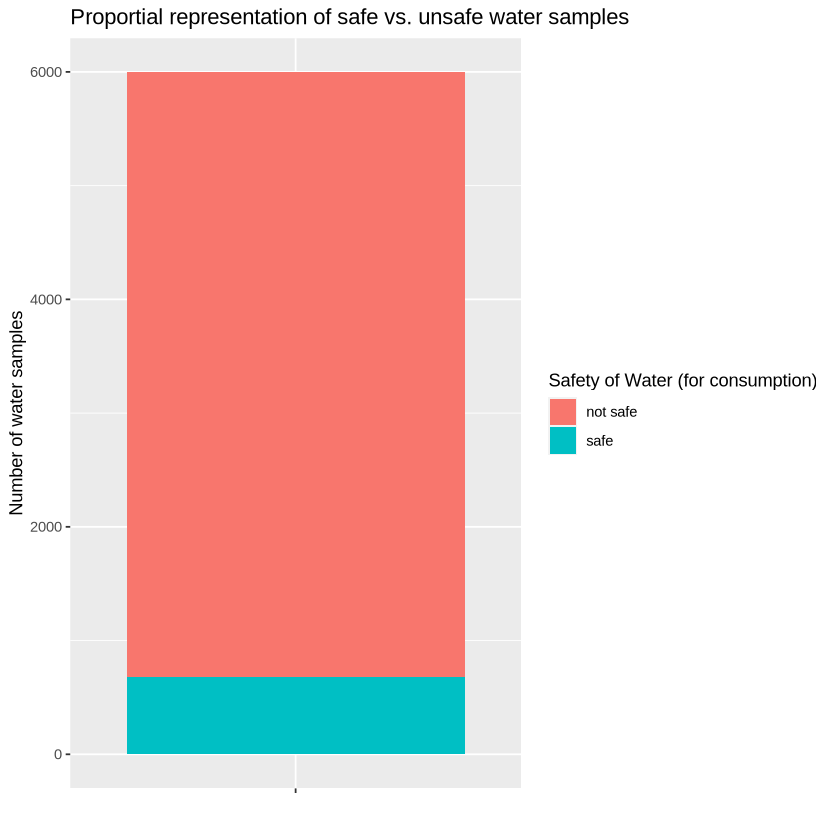

In [30]:
water_train_plot <- water_train_table |>
                    ggplot(aes(x="",y=count,fill=is_safe)) +
                    geom_bar(stat="identity") +
                    labs(x="",y="Number of water samples", fill="Safety of Water (for consumption)") +
                    ggtitle("Proportial representation of safe vs. unsafe water samples")

water_train_plot

*The graphic above showcases one of many plots that can describe our situation. In this case, the proportions of safe and unsafe water in the dataset respectively. The plotted bar graph us a rough idea about the data we're working with; we now know that there are more unsafe samples than safe samples.*

**Note:** *This was plotted using only the training data set, which was created in the code block prior to the one used to create this plot.*

## 3. Methods ##

To carry out this data analysis, we will be employing the k-nearest neighbors classification algorithm. This involves using the data on each existing observation's predictor values and whether or not the sample is safe to consume or not, and then using this data to "train our model," such that we can classify a new observation that only contains predictors, but is not yet labelled with a class yet. Then, we will use our model to classify it using the predictors (to label it as either safe, or unsafe for consumption). To do this, we find the k-nearest data points, such that the distance between the new obeservation and an existing observation in our dataset is the lowest, and then we simply choose whichever class the majority of the points have as our classification.

With this specific dataset, there are 20 predictors. However, for our uses, 20 predictor variables is too high of a number, therefore, as mentioned earlier, we will limit our model to use the 6 most common contaminants in water. As such, our usage of the dataset will pull from data surrounding arsenic, bacteria, lead, nitrates, nitrites, and viruses, all given in level per litre. By taking the most common contaminants as predictors, we will likely still get similar results, without the added complexity of creating observations that require measurements for un

## 4. Expected outcomes and significance ##

## References: ##

https://www.who.int/news-room/fact-sheets/detail/drinking-water

https://www.epa.gov/sites/default/files/2015-10/documents/ace3_drinking_water.pdf